In [5]:
import os
import pandas as pd
import glob

%matplotlib inline
import matplotlib.pyplot as plt

path = r'/home/ubuntu/new cels/T193 new' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename,delimiter =',')
    li.append(df)
f= pd.concat(li, axis=0, ignore_index=True)



In [3]:
f['PERIOD_START_TIME'] = pd.to_datetime(f['PERIOD_START_TIME'])
f['target']= ((f['Avg MCS PUSCH trans'] < 14) & (f['Avg RSSI for PUCCH'] > -95) & (f['Avg SINR for PUCCH'] < 2)).astype(int) # target2
 # MANUAL FILTER USED

In [4]:
r = lambda x: f.pivot_table(index='PERIOD_START_TIME', columns=('LNCEL name'),values= x)
f_2 = r ('Avg SINR for PUCCH')
f_3 = r('Avg SINR for PUSCH')
f_4 =r('Perc UL_SCH TB RTRANS')
f_5 =r('Avg RSSI for PUCCH')
f_6= r('Avg RSSI for PUSCH')
f_7 = r('Total E-UTRAN RRC conn stp SR')
f_8=r('E-UTRAN E-RAB stp SR')
f_9= r('PDCP SDU Volume, DL')
f_10=r('PDCP SDU Volume, UL')
f_1 = r('Avg UE pwr hr PUSCH')
f_11=r('target')


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


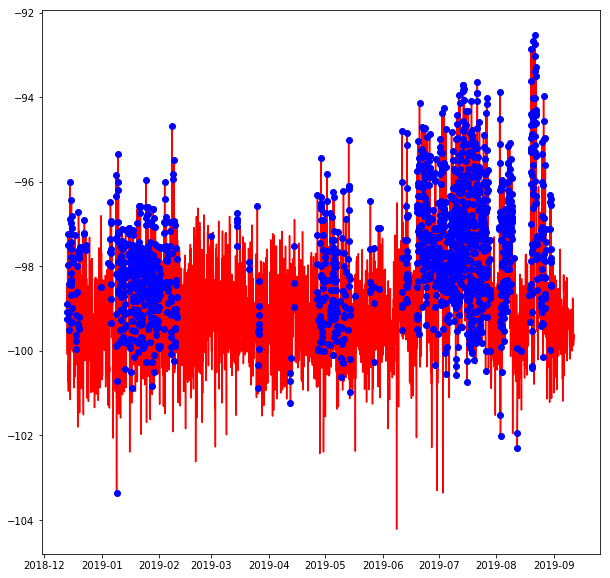

In [8]:
value = l['value']
value = pd.to_numeric(value, errors='coerce')
plt.figure(figsize = (10, 10))
time2 = df['time']
value2 = df['value']
value2 = pd.to_numeric(value2, errors='coerce') 
time=l['time']
#plt.plot(df['time'],df['value'])
plt.plot(time,value, 'r')
plt.plot(time2, value2, 'bo')
#plt.axvspan('2019-05-07','2019-07-31', color='yellow', alpha=0.5)

plt.show() 

USING PROPHET 

In [41]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

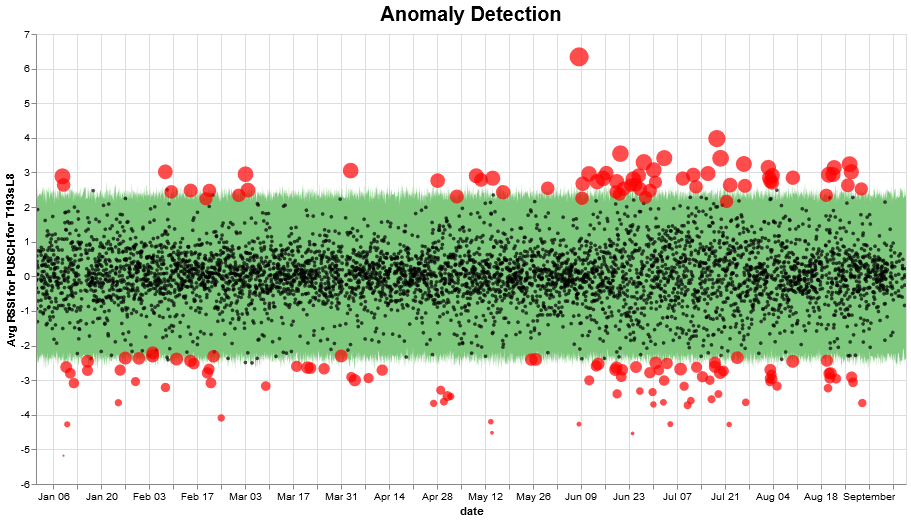

In [47]:
import altair as alt
alt.data_transformers.disable_max_rows()
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Avg RSSI for PUSCH for T193sL8'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Avg RSSI for PUSCH for T193sL8'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

USING MAHALANOBIS DISTANCE
    

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [21]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [22]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [23]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [24]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [25]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [26]:
import numpy as np
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)


In [28]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)
mean_distr = data_train.mean(axis=0)

In [29]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15)

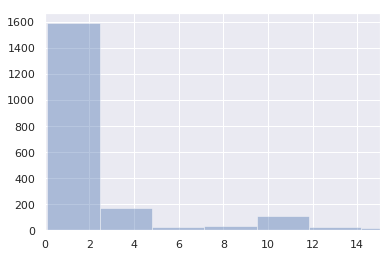

In [30]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

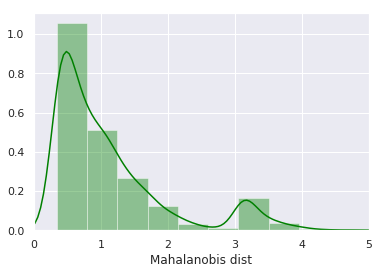

In [31]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [32]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
time,,,
2019-06-06 01:00:00,0.811289,3.356539,False
2019-06-06 02:00:00,0.352116,3.356539,False
2019-06-06 03:00:00,1.441197,3.356539,False
2019-06-06 04:00:00,1.079898,3.356539,False
2019-06-06 05:00:00,0.801424,3.356539,False


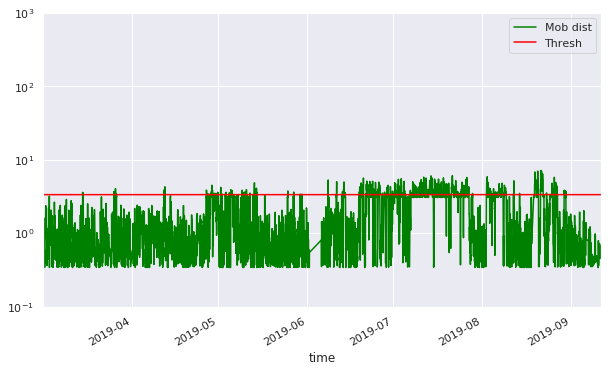

In [33]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])